# Pylops - signal reconstruction

### Author: M.Ravasi

In this notebook we will use the proximal gradient algorithm to solve a problem of signal reconstruction and compare its results with ISTA/FISTA or PyLops.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import warnings
#warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from copy import deepcopy
from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from scipy.signal import triang

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity      import *

from pyproximal.proximal import *
from pyproximal import ProxOperator
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.bregman import *
from pyproximal.utils import moreau

## 1D Interpolation

Consider the problem of reconstructing a regularly sampled signal of size $M$ from $N$ randomly selected samples:


$$\mathbf{y} = \mathbf{R} \mathbf{x}$$

where

$$\mathbf{y}= [y_1, y_2,...,y_N]^T, \qquad \mathbf{x}= [x_1, x_2,...,x_M]^T, \qquad $$

with $M>>N$ and R selects M elements from x at random locations

Create signal in frequency domain

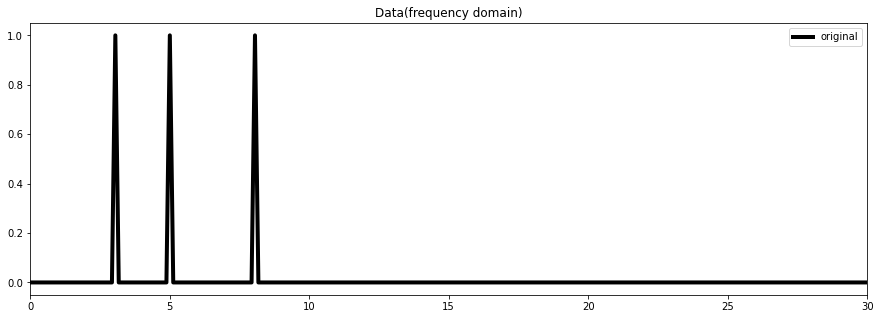

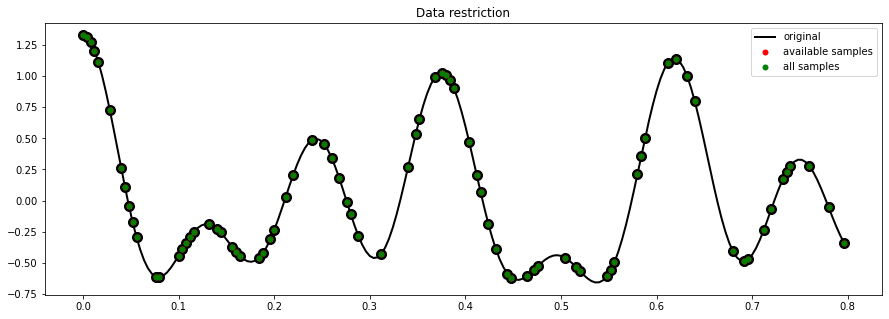

In [8]:
# Signal creation
N=200
dt=0.004
nfft=2**11
t = np.arange(N)*dt
f = np.fft.rfftfreq(nfft, dt)
ifreqs = [ 41, 25, 66]
freqs = f[ifreqs]

X = np.zeros(nfft//2+1, dtype='complex128')
X[ifreqs] = 1
FFTop = 10*FFT(N, nfft=nfft, real=True)
x = FFTop.H*X

fig = plt.figure(figsize=(15,5))
plt.plot(f, np.abs(X), 'k', lw=4, label='original')
plt.xlim(0,30)
plt.legend()
plt.title('Data(frequency domain)');

# subsampling locations
perc_subsampling=0.4
Nsub=int(np.round(N*perc_subsampling))

iava = np.sort(np.random.permutation(np.arange(N))[:Nsub])

# Create restriction operator
Rop = Restriction(N, iava, dtype='float64')
dottest(Rop,Nsub,N)

y     = Rop*x
ymask = Rop.mask(x)

# Visualize data
fig = plt.figure(figsize=(15,5))
plt.plot(t,       x,       'k' , lw=2,   label='original')
plt.plot(t[iava], x[iava], '.k', ms=20)
plt.plot(t[iava], y,       '.r', ms=10, label='available samples')
plt.plot(t,       ymask,   '.g', ms=10, label='all samples')
plt.legend()
plt.title('Data restriction');

### Sparsity promoting inversion

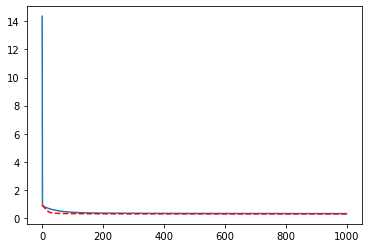

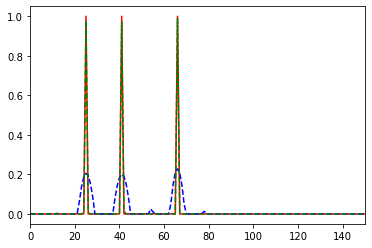

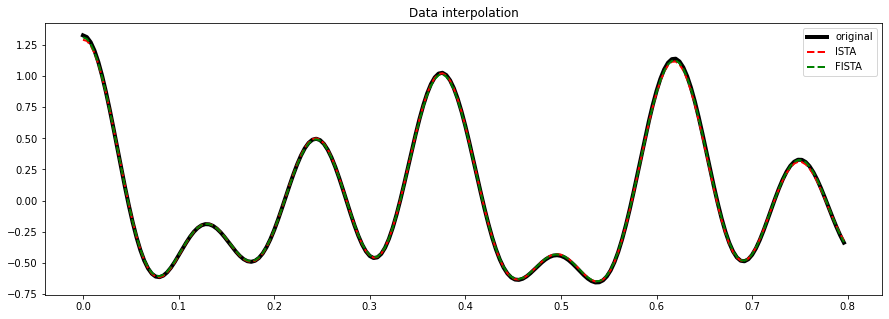

In [9]:
# Synthesis problem
Op = Rop*FFTop.H
L = np.abs((Op.H * Op).eigs(1)[0])
eps = 0.1
Xinv, niter, cost = ISTA(Op, y, niter=1000, alpha=0.95/L, eps=eps, 
                         tol=1e-8, monitorres=False, returninfo=True, show=False)
xinv = FFTop.H*Xinv

Xinv1, niter1, cost1 = FISTA(Op, y, niter=1000, alpha=0.95/L, eps=eps,  
                             tol=1e-8, returninfo=True, show=False)
xinv1 = FFTop.H*Xinv1

plt.figure()
plt.plot(cost)
plt.plot(cost1, '--r')

plt.figure()
plt.plot(np.abs(X),'r')
plt.plot(np.abs(Xinv), '--b')
plt.plot(np.abs(Xinv1), '--g')
plt.xlim(0,150)

fig = plt.figure(figsize=(15,5))
plt.plot(t,       x,              'k'   , lw=4,   label='original')
plt.plot(t,       xinv,  '--r' , lw=2,   label='ISTA')
plt.plot(t,       xinv1,  '--g' , lw=2,   label='FISTA')
plt.legend()
plt.title('Data interpolation');

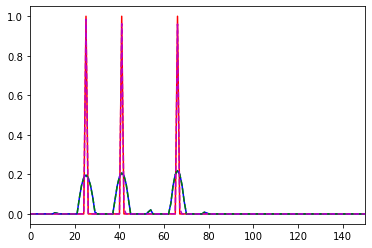

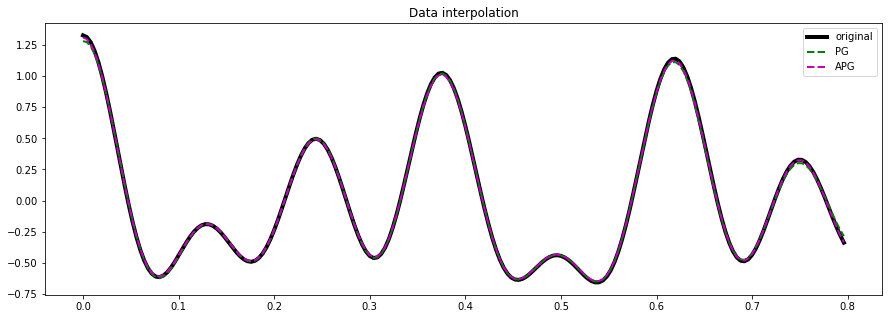

In [4]:
# Synthesis problem with proximal algs
l1 = L1()
l2 = L2(Op=Op, b=y)

L = np.abs((Op.H * Op).eigs(1)[0])
tau= 0.95/L
epsg = eps * 0.5
niter = 1000
Xpg = ProximalGradient(l2, l1, tau=tau, x0=np.zeros(FFTop.shape[0], dtype=np.complex), 
                       epsg=epsg, niter=niter, show=False)
xpg = FFTop.H*Xpg
Xapg = AcceleratedProximalGradient(l2, l1, tau=tau, x0=np.zeros(FFTop.shape[0], dtype=np.complex), 
                       epsg=epsg, niter=niter, show=False)
xapg = FFTop.H*Xapg

plt.figure()
plt.plot(np.abs(X),'r')
plt.plot(np.abs(Xinv), 'b')
plt.plot(np.abs(Xpg), '--g')
plt.plot(np.abs(Xapg), '--m')
plt.xlim(0,150)

fig = plt.figure(figsize=(15,5))
plt.plot(t,       x,              'k'   , lw=4,   label='original')
plt.plot(t,       xpg,  '--g' , lw=2,   label='PG')
plt.plot(t,       xapg,  '--m' , lw=2,   label='APG')
plt.legend()
plt.title('Data interpolation');

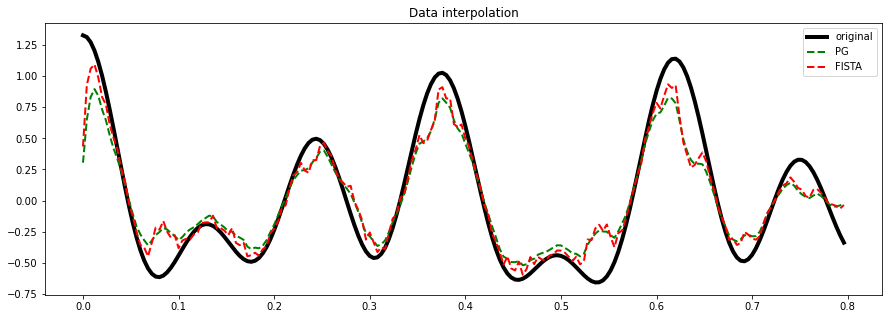

In [5]:
# Analysis problem with proximal algs
Rop.dtype = np.complex
FFTop1 = FFT(N, nfft=nfft, real=True)
l1 = Orthogonal(L1(), FFTop1)
l2 = L2(Op=Rop, b=y)

#L = np.abs((Rop.H * Rop).eigs(1)[0])
#tau= 0.99/L
#epsg = 0.01
#niter = 50
L = np.abs((Op.H * Op).eigs(1)[0])
tau= 0.95/L
epsg = eps * 0.5
niter = 1000

xpg = ProximalGradient(l2, l1, tau=tau, x0=np.zeros_like(x, dtype=np.complex), 
                       epsg=epsg, niter=niter, show=False)

xinv2, niter1, cost1 = FISTA(Rop, y, niter=100, alpha=0.99/L, eps=epsg,  
                             SOp=FFTop1.H, tol=1e-8, returninfo=True, show=False)

fig = plt.figure(figsize=(15,5))
plt.plot(t,       x,              'k'   , lw=4,   label='original')
plt.plot(t,       xpg,  '--g' , lw=2,   label='PG')
plt.plot(t,       xinv2,  '--r' , lw=2,   label='FISTA')
plt.legend()
plt.title('Data interpolation');

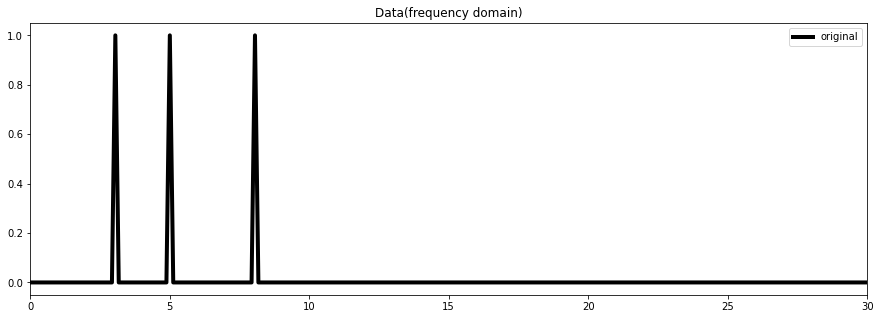

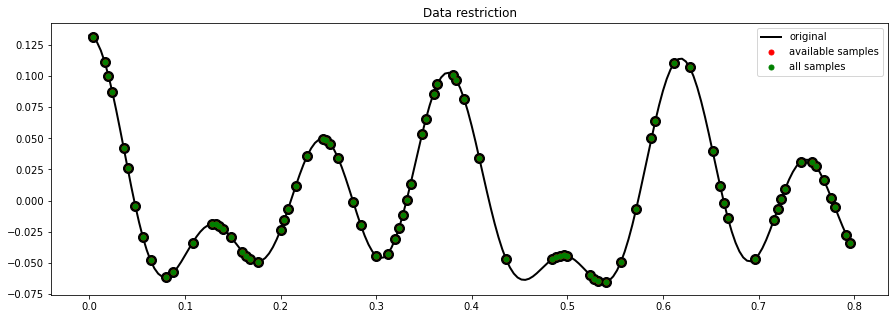

In [15]:
# Signal creation
N=200
dt=0.004
nfft=2**11
t = np.arange(N)*dt
f = np.fft.rfftfreq(nfft, dt)
ifreqs = [ 41, 25, 66]
freqs = f[ifreqs]

X = np.zeros(nfft//2+1, dtype='complex128')
X[ifreqs] = 1
FFTop = FFT(N, nfft=nfft, real=True)
x = FFTop.H*X

fig = plt.figure(figsize=(15,5))
plt.plot(f, np.abs(X), 'k', lw=4, label='original')
plt.xlim(0,30)
plt.legend()
plt.title('Data(frequency domain)');

# subsampling locations
perc_subsampling=0.4
Nsub=int(np.round(N*perc_subsampling))

iava = np.sort(np.random.permutation(np.arange(N))[:Nsub])

# Create restriction operator
Rop = Restriction(N, iava, dtype='float64')
dottest(Rop,Nsub,N)

y     = Rop*x
ymask = Rop.mask(x)

# Visualize data
fig = plt.figure(figsize=(15,5))
plt.plot(t,       x,       'k' , lw=2,   label='original')
plt.plot(t[iava], x[iava], '.k', ms=20)
plt.plot(t[iava], y,       '.r', ms=10, label='available samples')
plt.plot(t,       ymask,   '.g', ms=10, label='all samples')
plt.legend()
plt.title('Data restriction');

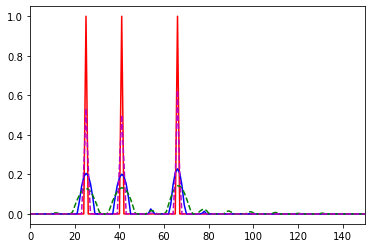

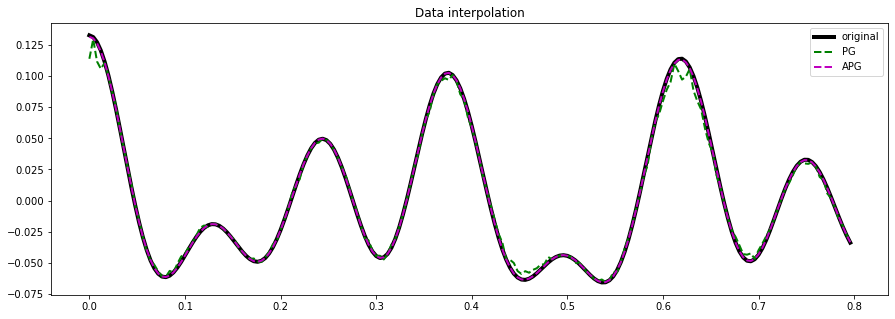

In [18]:
# Synthesis problem with proximal algs
Op = Rop*FFTop.H
l1 = L1()
l2 = L2(Op=Op, b=y)

L = np.abs((Op.H * Op).eigs(1)[0])
tau= 0.95/L
epsg = 1e-4
niter = 1000
Xpg = ProximalGradient(l2, l1, tau=tau, x0=np.zeros(FFTop.shape[0], dtype=np.complex), 
                       epsg=epsg, niter=niter, show=False)
xpg = FFTop.H*Xpg
Xapg = AcceleratedProximalGradient(l2, l1, tau=tau, x0=np.zeros(FFTop.shape[0], dtype=np.complex), 
                       epsg=epsg, niter=niter, show=False)
xapg = FFTop.H*Xapg

plt.figure()
plt.plot(np.abs(X),'r')
plt.plot(np.abs(Xinv), 'b')
plt.plot(np.abs(Xpg), '--g')
plt.plot(np.abs(Xapg), '--m')
plt.xlim(0,150)

fig = plt.figure(figsize=(15,5))
plt.plot(t,       x,              'k'   , lw=4,   label='original')
plt.plot(t,       xpg,  '--g' , lw=2,   label='PG')
plt.plot(t,       xapg,  '--m' , lw=2,   label='APG')
plt.legend()
plt.title('Data interpolation');

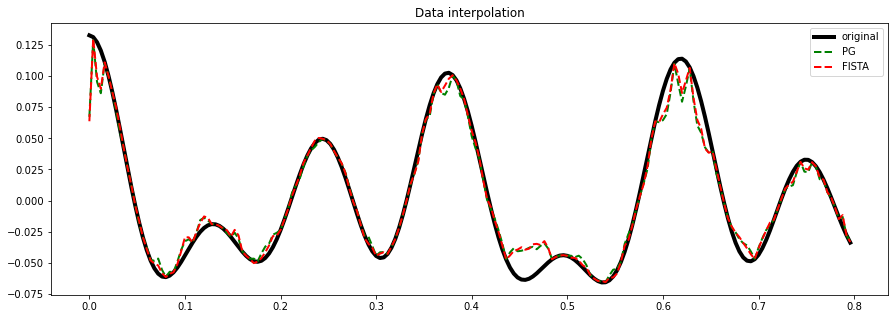

In [19]:
# Analysis problem with proximal algs
Rop.dtype = np.complex
l1 = Orthogonal(L1(), FFTop)
l2 = L2(Op=Rop, b=y)

L = np.abs((Op.H * Op).eigs(1)[0])
tau= 0.95/L
epsg = 1e-4
niter = 1000

xpg = ProximalGradient(l2, l1, tau=tau, x0=np.zeros_like(x, dtype=np.complex), 
                       epsg=epsg, niter=niter, show=False)

xinv2, niter1, cost1 = FISTA(Rop, y, niter=100, alpha=0.99/L, eps=epsg,  
                             SOp=FFTop1.H, tol=1e-8, returninfo=True, show=False)

fig = plt.figure(figsize=(15,5))
plt.plot(t,       x,              'k'   , lw=4,   label='original')
plt.plot(t,       xpg,  '--g' , lw=2,   label='PG')
plt.plot(t,       xinv2,  '--r' , lw=2,   label='FISTA')
plt.legend()
plt.title('Data interpolation');